In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [2]:
class VAE(nn.Module):
  def __init__(self, input_dim, z_dim, h_dim=200):
    super().__init__()
    self.input_dim = input_dim
    self.z_dim = z_dim
    self.h_dim = h_dim

    # encoder
    self.encoder = nn.Sequential(
        nn.Linear(self.input_dim, self.h_dim)
    ) 

    # mean and standard deviation
    self.mu = nn.Linear(self.h_dim, z_dim)
    self.sigma = nn.Linear(self.h_dim, z_dim)

    # decoder
    self.decoder = nn.Sequential(
        nn.Linear(z_dim, h_dim),
        nn.ReLU(),
        nn.Linear(h_dim, input_dim)
    )


  def encoder_forw(self, mzg):
    mzg = F.relu(self.encoder(mzg))
      
    mu = self.mu(mzg)
    sigma = self.sigma(mzg)

    epsilon = torch.randn_like(sigma)
    encoded = mu + sigma * epsilon

    return encoded, mu, sigma

    
  def decoder_forw(self, mzg):
    mzg = self.decoder(mzg)
    decoded = torch.sigmoid(mzg)

    return decoded


  def forward(self, mzg):
    encoded, mu, sigma = self.encoder_forw(mzg)

    output = self.decoder_forw(encoded)

    return output, mu, sigma



In [3]:
# train function
def train(num_epochs, model, train_loader, optimizer, loss_fn, input_dim):
    # training loop
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(train_loader))
        for i, (x, y) in loop:
            # Forward pass
            x = x.to(device).view(-1, input_dim)
            x_reconst, mu, sigma = model(x)

            # loss
            reconst_loss = loss_fn(x_reconst, x)
            kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            # optimizing and backpropagation
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

In [4]:
# parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 784 # 1*28*28
z_dim = 20
h_dim = 200
num_epochs = 20
batch_size = 64
lr = 3e-4

In [5]:
model_vae = VAE(input_dim=input_dim, z_dim=z_dim, h_dim=h_dim).to(device)

model_vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
  )
  (mu): Linear(in_features=200, out_features=20, bias=True)
  (sigma): Linear(in_features=200, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=784, bias=True)
  )
)

In [6]:
# Dataset loading
dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [7]:
# optimizer and loss functions
optimizer = torch.optim.Adam(model_vae.parameters(), lr=lr)
loss_fn = nn.BCELoss(reduction="sum")

In [8]:
# train our model 
train(num_epochs, model_vae, train_loader, optimizer, loss_fn, input_dim)

938it [00:14, 63.91it/s, loss=5.84e+3]
938it [00:11, 80.43it/s, loss=5.11e+3]
938it [00:11, 81.42it/s, loss=4.36e+3]
938it [00:11, 80.27it/s, loss=4.48e+3]
938it [00:11, 81.03it/s, loss=4.83e+3]
938it [00:11, 79.95it/s, loss=4.5e+3]
938it [00:11, 80.95it/s, loss=4.53e+3]
938it [00:11, 80.77it/s, loss=4.41e+3]
938it [00:11, 81.85it/s, loss=4.48e+3]
938it [00:11, 81.33it/s, loss=4.19e+3]
938it [00:11, 80.85it/s, loss=4.09e+3]
938it [00:11, 80.97it/s, loss=4.1e+3]
938it [00:11, 80.82it/s, loss=4.14e+3]
938it [00:11, 81.81it/s, loss=4.25e+3]
938it [00:11, 80.58it/s, loss=3.99e+3]
938it [00:11, 79.95it/s, loss=4.29e+3]
938it [00:11, 80.11it/s, loss=4.32e+3]
938it [00:11, 80.11it/s, loss=4.05e+3]
938it [00:11, 79.81it/s, loss=4.09e+3]
938it [00:11, 81.01it/s, loss=4.18e+3]


In [9]:
# Save model
FILE = "model_pytorch.pth"
torch.save(model_vae, FILE)

In [38]:
# Load model
loaded_model = torch.load('model_pytorch.pth').to(device)

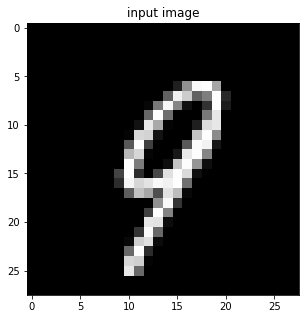

In [93]:
from matplotlib import pyplot as plt

image, _ = dataset[22] # random image

image = image.reshape(28, 28)


# in matplotlib ;
  # if image shape (x, x, 3), function works
  # if image shape (x, x), function works 
  # if image shape (x, x, 1), function not work

plt.rcParams["figure.figsize"] = [5, 5]
plt.title('input image')
plt.imshow(image, cmap='gray')
plt.show()

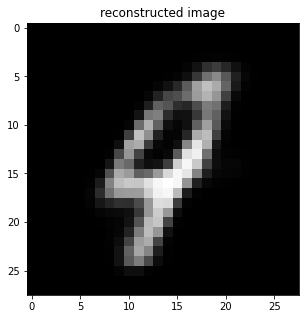

In [94]:
# Use our training model
image = image.view(1, 784)
image = image.to(device)

output = loaded_model(image.to(device))[0]
output = output.to('cpu')
output = output.detach().numpy()

output = output.reshape(28, 28)

plt.rcParams["figure.figsize"] = [5, 5]
plt.title('reconstructed image')
plt.imshow(output, cmap='gray')
plt.show()